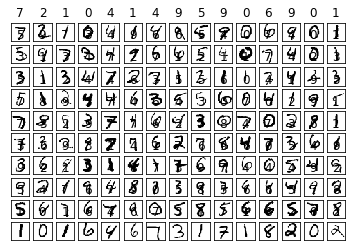

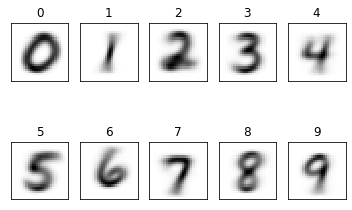

In [204]:
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp
file_data   = "/content/drive/My Drive/AssignmentFolder/Assignment09/mnist.csv"
handle_file = open(file_data, "r")
data        = handle_file.readlines()
handle_file.close()

size_row    = 28    # height of the image
size_col    = 28    # width of the image

num_image   = len(data)
count       = 0     # count for the number of images

#
# normalize the values of the input data to be [0, 1]
#
def normalize(data):

    data_normalized = (data - min(data)) / (max(data) - min(data))

    return(data_normalized)

#
# example of distance function between two vectors x and y
#
def distance(x, y):

    d = (x - y) ** 2
    s = np.sum(d)
    # r = np.sqrt(s)

    return(s)

#
# make a matrix each column of which represents an images in a vector form
#
list_image  = np.empty((size_row * size_col, num_image), dtype=float)
list_label  = np.empty(num_image, dtype=int)

for line in data:

    line_data   = line.split(',')
    label       = line_data[0]
    im_vector   = np.asfarray(line_data[1:])
    im_vector   = normalize(im_vector)

    list_label[count]       = label
    list_image[:, count]    = im_vector

    count += 1

#
# plot first 150 images out of 10,000 with their labels
#
f1 = plt.figure(1)

for i in range(150):

    label       = list_label[i]
    im_vector   = list_image[:, i]
    im_matrix   = im_vector.reshape((size_row, size_col))

    plt.subplot(10, 15, i+1)
    plt.title(label)
    plt.imshow(im_matrix, cmap='Greys', interpolation='None')

    frame   = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)


#plt.show()

#
# plot the average image of all the images for each digit
#
f2 = plt.figure(2)

im_average  = np.zeros((size_row * size_col, 10), dtype=float)
im_count    = np.zeros(10, dtype=int)

for i in range(num_image):

    im_average[:, list_label[i]] += list_image[:, i]
    im_count[list_label[i]] += 1

for i in range(10):

    im_average[:, i] /= im_count[i]

    plt.subplot(2, 5, i+1)
    plt.title(i)
    plt.imshow(im_average[:,i].reshape((size_row, size_col)), cmap='Greys', interpolation='None')

    frame   = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)

plt.show()

In [4]:
!curl https://colab.chainer.org/install | sh -
#cupy library를 사용하기 위해 사용

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1580  100  1580    0     0   3969      0 --:--:-- --:--:-- --:--:--  3969
+ apt -y -q install cuda-libraries-dev-10-0
Reading package lists...
Building dependency tree...
Reading state information...
cuda-libraries-dev-10-0 is already the newest version (10.0.130-1).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.
+ pip install -q cupy-cuda100  chainer 
+ set +ex
Installation succeeded!


In [0]:

"""고침1"""
train_data = list_image[0:, 0:6000]
X_train = train_data

test_data = list_image[0:, 6000:10000]
X_test = test_data
#효율적인 값 도출을 위해
#나중에 지우기
np.random.seed(1000)

"""추가1"""
#np.random.normal(loc = 0.0, scale = 0.5, size = (196, 784))
u = np.random.randn(196, 784)
v = np.random.randn(49, 196)
w = np.random.randn(10, 49)
#train
X = np.zeros((784, 1))
Y = np.zeros((196, 1))
Z = np.zeros((49, 1))
H = np.zeros((10, 1))
#test
x = np.zeros((784, 1))
y = np.zeros((196, 1))
z = np.zeros((49, 1))
h = np.zeros((10, 1))
#bias
bias = 1


In [0]:
def sigmoid (z):
    return 1 / (1 + np.exp(-z))
 
def sig_der(z):
    return (z*(1-z))

In [0]:
#구해야 하는 label
train_label = list_label[0:6000]
real_label = np.zeros((10, 6000))
#label
for i in range(0, 6000):
  for j in range(0, 10):
    if j == train_label[i]:
      real_label[j][i] = 1
    else:
      real_label[j][i] = 0

test_label = list_label[6000:10000]
test_real_label = np.zeros((10, 4000))
#test label
for i in range(0, 4000):
  for j in range(0, 10):
    if j == test_label[i]:
      test_real_label[j][i] = 1
    else:
      test_real_label[j][i] = 0

In [192]:
#use mini batch 

cycle = 30
learning_rate = 0.03
train_loss_list = []
test_loss_list = []

#accuracy
train_accuracy_list = []
test_accuracy_list = []
train_correct = 0
test_correct = 0

threshold = 0.00001

correct_label = []
correct_img = []
#incorrect_label = np.zeros(0, 10000)

train_loss_list.append(0)
for j in range(cycle):
  for i in range(0, 6000):
    #mini_batch
    X = X_train[0:, i:i+1]
    Y = sigmoid(cp.dot(u, X))
    Z = sigmoid(cp.dot(v, Y))
    H = sigmoid(cp.dot(w, Z))

    R = real_label[0:,i:i+1]
    #-값을 가지기도 해서 graph상에 표시할 때는 abs값 적용
    H_loss = H - R
    #to use backpropagation
    #bias는 어차피 1이므로 신경쓰지 않아도 된다
    H_der = H_loss * sig_der(H)
    Z_loss = cp.dot(w.T, H_der)
    Z_der = Z_loss * sig_der(Z)
    Y_loss = cp.dot(v.T, Z_der)
    Y_der = Y_loss * sig_der(Y)

    tmpw = w - learning_rate * Z.T * H_der
    tmpv = v - learning_rate * Y.T * Z_der
    tmpu = u - learning_rate * X.T * Y_der
    if i < 4000 :
      #바꿔주기 전 test도 check

      x = X_test[0:, i: (i+1)]
      y = sigmoid(cp.dot(u, x))
      z = sigmoid(cp.dot(v, y))
      h = sigmoid(cp.dot(w, z))
      
      r = test_real_label[0:, i: (i + 1)]
      h_loss = h - r

      w = tmpw
      v = tmpv
      u = tmpu
      if test_real_label[h.argmax()][i] == 1:
        
        test_correct += 1

    if real_label[H.argmax()][i] == 1:
      train_correct += 1
      correct_label.append(H.argmax())
      correct_img.append(X)

  train_loss_list.append(np.mean(np.abs(H_loss)))
  test_loss_list.append(np.mean(np.abs(h_loss)))
  if abs(train_loss_list[j] - train_loss_list[j + 1]) < threshold:
    print("converge")
    break
  print("cycle : ",j)
  train_accuracy_list.append(train_correct / 6000)
  test_accuracy_list.append(test_correct / 4000)
  train_correct = 0
  test_correct = 0

del train_loss_list[0]

cycle :  0
cycle :  1
cycle :  2
cycle :  3
cycle :  4
cycle :  5
cycle :  6
cycle :  7
cycle :  8
cycle :  9
cycle :  10
cycle :  11
cycle :  12
cycle :  13
cycle :  14
cycle :  15
cycle :  16
cycle :  17
cycle :  18
cycle :  19
cycle :  20
cycle :  21
cycle :  22
cycle :  23
cycle :  24
cycle :  25
cycle :  26
cycle :  27
cycle :  28
cycle :  29


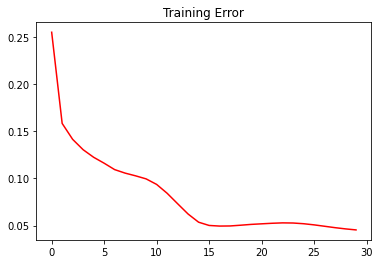

In [193]:

plt.plot(train_loss_list,c='red') #plot Training Error
plt.title('Training Error')
plt.show()

In [194]:
print(train_accuracy_list[len(train_accuracy_list) - 1])

0.8148333333333333


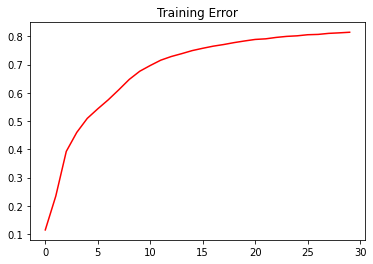

In [195]:
plt.plot(train_accuracy_list,c='red') #plot Training Error
plt.title('Training Error')
plt.show()

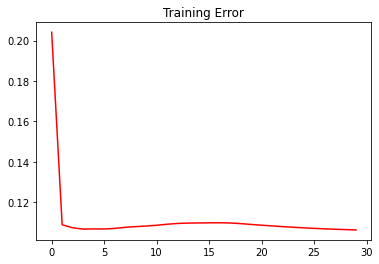

In [196]:

plt.plot(test_loss_list,c='red') #plot Training Error
plt.title('Training Error')
plt.show()

In [197]:
print(test_accuracy_list[len(test_accuracy_list) - 1])

0.7335


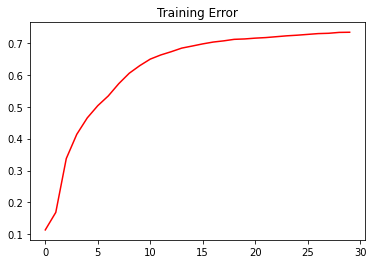

In [198]:

plt.plot(test_accuracy_list,c='red') #plot Training Error
plt.title('Training Error')
plt.show()

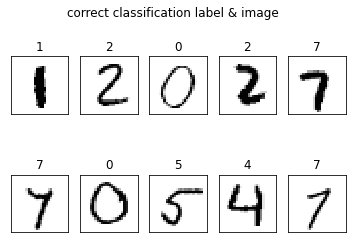

In [208]:
for i in range(10): #correct classification image
  plt.subplot(2, 5,i+1)
  plt.title(correct_label[i+3000])
  plt.imshow(correct_img[i+3000].reshape(28,28, order = 'C'), cmap='Greys', interpolation='None')
  frame = plt.gca()
  frame.axes.get_xaxis().set_visible(False)
  frame.axes.get_yaxis().set_visible(False)

plt.suptitle('correct classification label & image')
plt.show()

In [0]:
for i in range(10): #correct classification image
  plt.subplot(2,5,i+1)
  plt.title(correct_classification_label[i])
  plt.imshow(correct_classification_img[i].reshape(28,28, order = 'C'), cmap='Greys', interpolation='None')
  frame = plt.gca()
  frame.axes.get_xaxis().set_visible(False)
  frame.axes.get_yaxis().set_visible(False)

plt.suptitle('correct classification label & image')
plt.show()

In [0]:
#.T붙여서 사용
"""고침1"""
train_data = list_image[0:, 0:6000]
X_train = train_data

test_data = list_image[0:, 6000:10000]
X_test = test_data

"""추가1"""
u = np.random.randn(196, 784)
v = np.random.randn(49, 196)
w = np.random.randn(10, 49)


In [0]:
#alpha 바꾸기 전 저장용
cycle = 30
learning_rate = 0.1
train_loss_list = []
#accuracy
correct = 0
train_accuracy_list = []




threshold = 0.00001

for j in range(cycle):
  for i in range(0, 6000):
    #use mini_batch
    X = X_train[i]
    Y = sigmoid(cp.dot(X, u))
    Z = sigmoid(cp.dot(Y, v))
    H = sigmoid(cp.dot(Z, w))

    r = np.zeros(10)
    r[y_train[i]] = 1.0

    H_loss = H - r
    #to use backpropagation
    H_der = H_loss * sigmoid_derivative(H)
    Z_loss = H_der.dot(w.T)
    Z_der = Z_loss * sigmoid_derivative(Z)
    Y_loss = Z_der.dot(v.T)
    Y_der = Y_loss * sigmoid_derivative(Y)

    tmpw = w - learning_rate * cp.reshape(Z, (-1, 1)) * H_loss
    tmpv = v - learning_rate * cp.reshape(Y, (-1, 1)) * Z_loss
    tmpu = u - learning_rate * cp.reshape(X, (-1, 1)) * Y_loss

    w = tmpw
    v = tmpv
    u = tmpu

    train_loss_list.append(np.mean(np.abs(H_loss)))
    if abs(train_loss_list[i - 1] - train_loss_list[i]) < threshold:
      break_check = True
      break
  print("cycle :",cycle)
  if break_check == True:
    break
#loss_Y = layer_3_delta.dot()
